In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F

from sentence_transformers import SentenceTransformer, InputExample, losses, models, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from datasets import load_dataset, Dataset

from tqdm import tqdm
import logging

from datetime import datetime

In [2]:
from pooling import my_pooling
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
sentence_trans = SentenceTransformer('sentence-transformers/multi-qa-distilbert-cos-v1', device = device)
sentence_trans[1] = my_pooling(use_layernorm=True)
# model._first_module()
# sentence_trans

C:\Users\Dollcrusader\anaconda3\envs\ML_Final\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
dataset = load_dataset("mteb/cqadupstack-physics", "corpus")

In [5]:
index = dataset['corpus'].shape[0]
train_index = int(index*0.6)
dev_index = int(index*0.8)

index = int(index)
train_index = int(train_index)
dev_index = int(dev_index)

In [6]:
dataset_shuffled = dataset['corpus'].shuffle(seed=42)
train_samples = Dataset.from_dict(dataset_shuffled[0:train_index])
dev_samples = Dataset.from_dict(dataset_shuffled[train_index:dev_index])
test_samples = Dataset.from_dict(dataset_shuffled[dev_index:index])

In [7]:
from utils import shuffle_no_fixed_point

def InputData_tri(dataset):
    samples_set = []
    for title, text, rand_text in zip(dataset['title'], dataset['text'], shuffle_no_fixed_point(dataset['text'])):
        related = InputExample(texts=[title, text], label = 1.0)
        unrelated = InputExample(texts=[title, rand_text], label = 0.0)
        samples_set.append(related)
        samples_set.append(unrelated)
    return samples_set

In [8]:
train_samples_set = InputData_tri(train_samples)
test_samples_set = InputData_tri(test_samples)
dev_samples_set = InputData_tri(dev_samples)

In [9]:
scores = []
label = []
for data in test_samples_set:
    query_emb = sentence_trans.encode(data.texts[0])
    doc_emb = sentence_trans.encode(data.texts[1])
    scores.append(util.dot_score(query_emb, doc_emb)[0].cpu().tolist()[0])
    label.append(data.label)

In [10]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
label_np = np.array(label)
scores_np = np.array(scores)
auc = roc_auc_score(np.abs(label_np), np.abs(scores_np))
print("Auc:", auc)

Auc: 0.9983842523786071


In [11]:
threshold = 0.9
predicted_labels = (np.abs(scores_np) >= threshold).astype(int)

# Step 2: Compute the F1 score
f1 = f1_score(label_np, predicted_labels)

# Step 3: Compute the accuracy
accuracy = accuracy_score(label_np, predicted_labels)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

F1 Score: 0.02880658436213992
Accuracy: 0.5073068893528184


In [12]:
score = 0
i = 0
for l, s in zip(label_np, scores_np):
    if l == 1.0:
        score += s
        i += 1
print("Average score:", score/i)

Average score: 0.6376100213942142


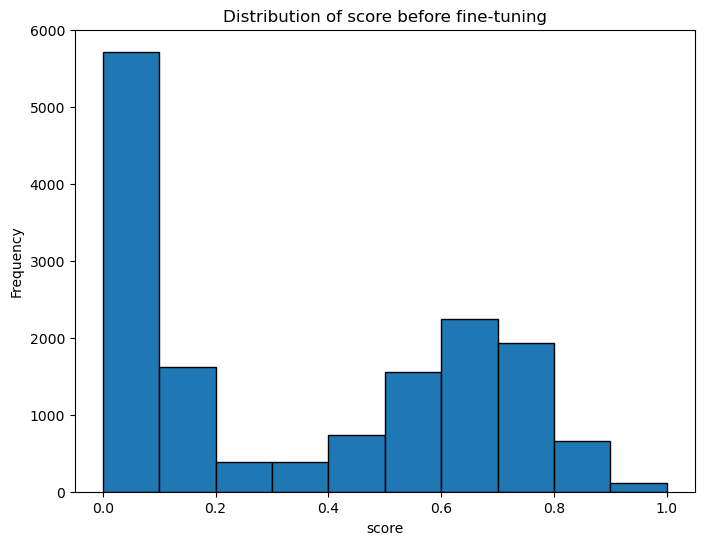

In [14]:
import matplotlib.pyplot as plt
# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(np.abs(scores_np), bins=10, edgecolor='black')
plt.xlabel('score')
plt.ylabel('Frequency')
plt.title('Distribution of score before fine-tuning')
plt.savefig('Before fine-tuning')